<a href="https://colab.research.google.com/github/JosepRoo/MNA/blob/main/Equipo39_semana09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof. Luis Eduardo Falcón Morales

### **Actividad Semana 9 - Traducciones y Clasificación de Textos**

### **EQUIPO 39**

*   Josep Romagosa Llorden - **A01374637**
*   Herbert Joadan Romero Villarreal - **A01794199**
*   Eduardo Rodriguez Ramirez - **A01794892**
*   Rodrigo Ildefonso Roman Guzman - **A01794225**
*   Luis Fernando Rojas Marta - **A00757351**




In [ ]:
%%capture
! pip install transformers[torch] datasets
! pip install accelerate -U
! pip install sacremoses

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from datasets import Dataset
from transformers import MarianMTModel, MarianTokenizer, GPT2Tokenizer, GPT2LMHeadModel
import seaborn as sns
import matplotlib.pyplot as plt
import random
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Instrucciones:

En la actividad de esta semana trabajarás en equipos mediante el uso de Transformers en combinación con LLMs.

Nos apoyaremos en la plataforma de HuggingFace (HF): https://huggingface.co/

La plataforma de HF está muy bien documentada, es de acceso abierto, pero deberás generar una cuenta sin costo para su uso. En ocasiones deberás generar una clave para el uso de algunos modelos; pero es solo para el control del uso de dicha plataforma y no genera algún costo para su uso educativo o de investigación, ni tampoco se requiere introducir una tarjeta de crédito, al menos hasta ahora.

En particular en esta actividad usaremos algunos modelos Transformer y de LLM. El objetivo principal es que te familiarices con ambas técnicas y puedas empezar a ver sus ventajas y desventajas para futuros proyectos en los cuales desees implementarlos.

En particular puedes apoyarte en el siguiente tutorial de la misma comunidad de HF para llevar a cabo la preparación, tokenización y entrenamiento del modelo en tu JupyterNotebook: https://huggingface.co/blog/sentiment-analysis-python





### **1. Descarga el archivo amazonbaby5000.csv**

Descarga el archivo *amazonbaby5000.csv* que se encuentra en Canvas. Este archivo está formado de 5 mil comentarios en inglés sobre productos para bebé adquiridos a través de la plataforma de Amazon.

In [ ]:
# Se carga el CSV desde nuestro Drive
df = pd.read_csv('/content/drive/Shared drives/NLP/semana9/Amazon Baby 5000.csv')
df

,review,rating
0,I think it is more Expensive than drugstore th...,0
1,"When I saw this on Amazon, I put it into my wi...",1
2,We really like these valances. They have such...,1
3,No light emits from the night light. They pain...,0
4,I was really hoping for this to be a conventie...,0
...,...,...
4995,I like that this carrier is like the Moby in h...,1
4996,The box was damaged upon arrival. I was afraid...,1
4997,Purchased for graduation. Rec'd in 2 days like...,1
4998,For all of the reviews that said this car seat...,0


### **2. Realiza la particion entrenamiento y prueba**
Realiza una partición de los datos en el porcentaje que consideres adecuado, en entrenamiento y prueba.

In [ ]:
# Generamos conjuntos de etrenamiento y prueba 80/20
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f'Tamaño del conjunto de entrenamiento: {len(train_df)}')
print(f'Tamaño del conjunto de prueba: {len(test_df)}')

Tamaño del conjunto de entrenamiento: 4000
Tamaño del conjunto de prueba: 1000


### **3. Utiliza un modelo Transformer de HuggingFace para análisis de sentimiento**
Utiliza un modelo Transformer de HuggingFace para análisis de sentimiento en inglés y lleva a cabo la predicción de los comentarios en los siguientes casos:

#### **3.a Utiliza uno de los modelos Transformer pre-entrenados que consideres adecuado de DistilBERT**

Utiliza uno de los modelos Transformer pre-entrenados que consideres adecuado de DistilBERT de Huggingface para análisis de sentimiento y lleva a cabo el entrenamiento y evaluación del desempeño con exatitud (accuracy) y matriz de confusión.

*NOTA: Recuerda obtener el porcentaje de las clases positivas y negativas para tener una idea clara de si el modelo encontrado queda subentrenado.*

In [ ]:
# Importar el Tokenizador y el Modelo:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Función de Tokenización:
def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True)

# Crear Conjuntos de Datos:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Aplicar Tokenización a los Conjuntos de Datos:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Renombrar la Columna de Etiquetas:
train_dataset = train_dataset.rename_column("rating", "labels")
test_dataset = test_dataset.rename_column("rating", "labels")

# Formatear los Conjuntos de Datos:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Definir Argumentos de Entrenamiento:
'''
Configura los argumentos de entrenamiento, incluyendo la tasa de aprendizaje, el tamaño del batch, el número de épocas, etc.
'''
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Usamos eval_strategy para evitar el Warning
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Crear el Entrenador y Entrenar el Modelo:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# Evaluar el Modelo:
results = trainer.evaluate()
results

Epoch,Training Loss,Validation Loss
1,No log,0.267217
2,0.248500,0.338090
3,0.248500,0.335533


{'eval_loss': 0.3355330526828766,
 'eval_runtime': 17.0504,
 'eval_samples_per_second': 58.65,
 'eval_steps_per_second': 3.695,
 'epoch': 3.0}

In [ ]:
# Evaluamos el modelo
results = trainer.evaluate()
print("Evaluation Results:", results)

# Predecimos en el conjunto de prueba
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

# Calculamos la precisión (accuracy)
accuracy = accuracy_score(labels, predictions)
print("Accuracy:", accuracy)

# Generamos el reporte de clasificación
class_report = classification_report(labels, predictions)
print("Classification Report:\n", class_report)

Epoch,Training Loss,Validation Loss
0,No log,0.300786


Evaluation Results: {'eval_loss': 0.30078619718551636}
Accuracy: 0.874
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.69      0.72       240
           1       0.90      0.93      0.92       760

    accuracy                           0.87      1000
   macro avg       0.83      0.81      0.82      1000
weighted avg       0.87      0.87      0.87      1000



Confusion Matrix:
 [[165  75]
 [ 51 709]]


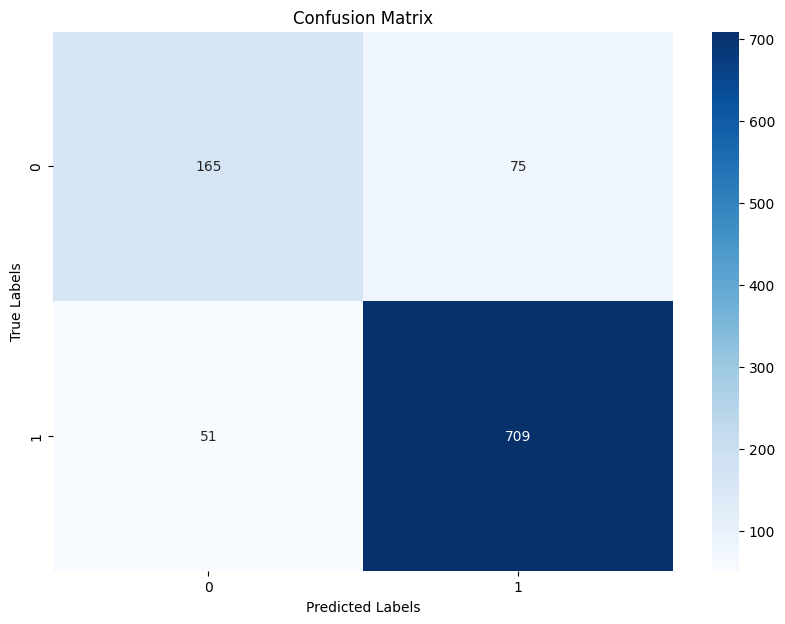

In [ ]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(labels, predictions)
print("Confusion Matrix:\n", conf_matrix)

# Visualizar la matriz de confusión utilizando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculamos y mostramos el porcentaje de las clases positivas y negativas
label_counts = np.bincount(labels)
label_percentages = label_counts / len(labels) * 100

# 0 es clase negativa y 1 es clase positiva
class_names = ['Negative', 'Positive']

# Imprimimos los porcentajes con etiquetas descriptivas
for class_name, percentage in zip(class_names, label_percentages):
    print(f"{class_name} Class: {percentage:.2f}%")

Negative Class: 24.00%
Positive Class: 76.00%


#### **3.b DistilBERT con fine-tuning**
Realiza una partición del conjunto de entrenamiento en uno nuevo de entrenamiento y validación, con los porcentajes que consideres adecuados y utilizando el mismo modelo DistilBERT del inciso anterior, ajusta sus hiperparámetros (fine-tuning) para entrenar y evaluar el desempeño de este nuevo modelo.

In [ ]:
# Teniendo en cuenta que train_df y test_df ya están definidos con tus datos
# Crear una partición del conjunto de entrenamiento en entrenamiento y validación
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convertir DataFrames a Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizador y modelo de DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Función de tokenización
def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True)

# Tokenizar conjuntos de datos
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Renombrar la columna de etiquetas
train_dataset = train_dataset.rename_column("rating", "labels")
val_dataset = val_dataset.rename_column("rating", "labels")
test_dataset = test_dataset.rename_column("rating", "labels")

# Formatear conjuntos de datos para PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Definir argumentos de entrenamiento con evaluación durante cada época
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Crear el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Usar el nuevo conjunto de validación
)

# Entrenar el modelo
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2560 [00:00<?, ? examples/s]

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.240833
2,No log,0.220480
3,No log,0.253712


TrainOutput(global_step=480, training_loss=0.23110448519388835, metrics={'train_runtime': 389.099, 'train_samples_per_second': 19.738, 'train_steps_per_second': 1.234, 'total_flos': 1017349621678080.0, 'train_loss': 0.23110448519388835, 'epoch': 3.0})

In [ ]:
# Evaluar el modelo en el conjunto de validación
val_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation Results:", val_results)

# Evaluar el mejor modelo en el conjunto de prueba
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test Results:", test_results)

# Predecir en el conjunto de prueba
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

# Calcular la precisión (accuracy)
accuracy = accuracy_score(labels, predictions)
print("Accuracy:", accuracy)

Validation Results: {'eval_loss': 0.2537120282649994, 'eval_runtime': 10.9241, 'eval_samples_per_second': 58.586, 'eval_steps_per_second': 3.662, 'epoch': 3.0}
Test Results: {'eval_loss': 0.31347987055778503, 'eval_runtime': 17.0405, 'eval_samples_per_second': 58.684, 'eval_steps_per_second': 3.697, 'epoch': 3.0}
Accuracy: 0.898


In [ ]:
# Generar el reporte de clasificación
class_report = classification_report(labels, predictions)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79       240
           1       0.93      0.94      0.93       760

    accuracy                           0.90      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.90      0.90      0.90      1000



Confusion Matrix:
 [[187  53]
 [ 49 711]]


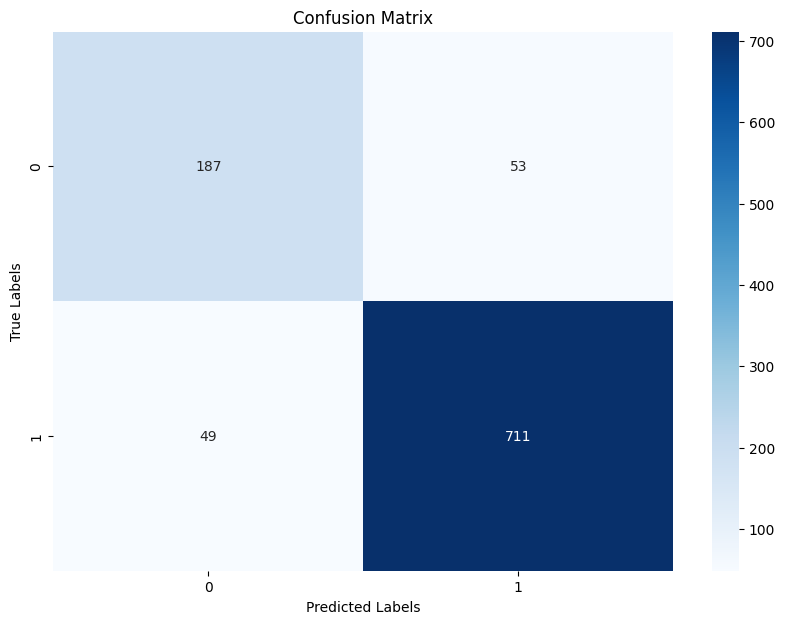

In [ ]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(labels, predictions)
print("Confusion Matrix:\n", conf_matrix)

# Visualizar la matriz de confusión utilizando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculamos y mostramos el porcentaje de las clases positivas y negativas
label_counts = np.bincount(labels)
label_percentages = label_counts / len(labels) * 100

# 0 es clase negativa y 1 es clase positiva
class_names = ['Negative', 'Positive']

# Imprimimos los porcentajes con etiquetas descriptivas
for class_name, percentage in zip(class_names, label_percentages):
    print(f"{class_name} Class: {percentage:.2f}%")

Negative Class: 24.00%
Positive Class: 76.00%


#### **3.c Evaluación mejor modelo**

Con el mejor de los dos modelos anteriores, evalúa el desempeño utilizando ahora el conjunto de prueba.

In [ ]:
# Evaluar el mejor modelo (en este caso, el modelo ajustado) en el conjunto de prueba

# evaluamos el modelo en el conjunto de prueba
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test Results:", test_results)

# predecimos en el conjunto de prueba
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

# calculamos la precisión (accuracy)
accuracy = accuracy_score(labels, predictions)
print("Accuracy:", accuracy)

# generamos el reporte de clasificación
class_report = classification_report(labels, predictions)
print("Classification Report:\n", class_report)

Test Results: {'eval_loss': 0.31347987055778503, 'eval_runtime': 16.5048, 'eval_samples_per_second': 60.588, 'eval_steps_per_second': 3.817, 'epoch': 3.0}
Accuracy: 0.898
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79       240
           1       0.93      0.94      0.93       760

    accuracy                           0.90      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.90      0.90      0.90      1000



Confusion Matrix:
 [[187  53]
 [ 49 711]]


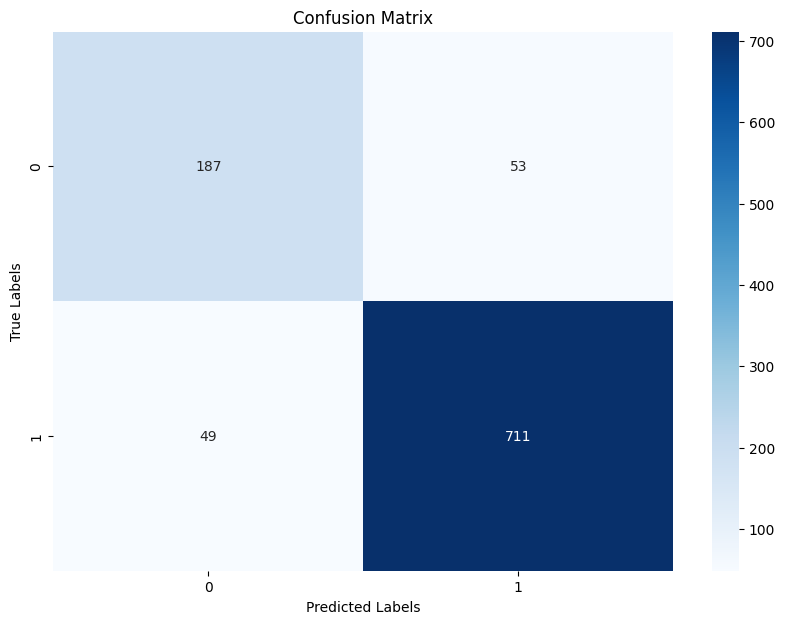

In [ ]:
# generamos la matriz de confusión
conf_matrix = confusion_matrix(labels, predictions)
print("Confusion Matrix:\n", conf_matrix)

# Visualizar la matriz de confusión utilizando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculamos y mostramos el porcentaje de las clases positivas y negativas
label_counts = np.bincount(labels)
label_percentages = label_counts / len(labels) * 100

# 0 es clase negativa y 1 es clase positiva
class_names = ['Negative', 'Positive']

# Imprimimos los porcentajes con etiquetas descriptivas
for class_name, percentage in zip(class_names, label_percentages):
    print(f"{class_name} Class: {percentage:.2f}%")

Negative Class: 24.00%
Positive Class: 76.00%


#### **3.d Comentarios**

> El proceso de fine-tuning de DistilBERT permitió obtener una mejora significativa en la evaluación comparado con el modelo preentrenado. Originalmente, el modelo preentrenado alcanzó una precisión del 87%, mientras que después del ajuste, la precisión aumentó al 90%. Esta mejora también se reflejó en la precisión y recall para las clases positivas y negativas, indicando un modelo más robusto y equilibrado.

> La elección del modelo ajustado como el mejor modelo se basó en su rendimiento superior en el conjunto de prueba. No solo mantuvo una mejor precisión general, sino que también demostró una mayor capacidad de generalización con los ejemplos no vistos durante el entrenamiento. La matriz de confusión final mostró un mejor equilibrio entre las predicciones, con una reducción en los falsos positivos y falsos negativos. Esto nos indica que el modelo ajustado tiene una mejor sensibilidad y especificidad, lo que es crucial para aplicaciones prácticas.

> El resultado después del fine-tuning para este análisis de sentimientos ha resultado en un modelo más eficiente para interpretar y clasificar las reseñas. Esto subraya la importancia y utilidad de ajustar los modelos preentrenados a contextos específicos de las aplicaciones. En conclusión, el fine-tuning no solo mejora la precisión, sino que también asegura que el modelo sea más adaptable y preciso en tareas específicas, lo que es esencial para el éxito en entornos del mundo real.


### **4 Comparación simple entre un modelo Transformer pre-entrenado vs LLM**
En este ejercicio vas a realizar una comparación simple entre un modelo Transformer pre- entrenado para traducción de inglés a español, con un modelo LLM (Large Language Model). Para ello selecciona de manera aleatoria 10 comentarios del conjunto de AmazonBaby5000.

#### **4.a Utiliza el modelo Tansformer pre-entrenado**

Utiliza el modelo Tansformer pre-entrenado para traducción de inglés a español llamado Helsinki-NLP/opus-mt-en-es de Huggingface y traduce los 10 comentarios que seleccionaste.

In [ ]:
# Seleccionar 10 comentarios aleatorios del DataFrame df
random_comments = df.sample(n=10, random_state=42)['review'].tolist()

# Inicializar el modelo de traducción (Helsinki-NLP/opus-mt-en-es)
translation_model_name = 'Helsinki-NLP/opus-mt-en-es'
translation_tokenizer = MarianTokenizer.from_pretrained(translation_model_name)
translation_model = MarianMTModel.from_pretrained(translation_model_name)

# Inicializar el modelo LLM (GPT-2)
llm_model_name = 'gpt2'
llm_tokenizer = GPT2Tokenizer.from_pretrained(llm_model_name)
llm_model = GPT2LMHeadModel.from_pretrained(llm_model_name)

# Añadir un token de padding al tokenizador de GPT-2
llm_tokenizer.pad_token = llm_tokenizer.eos_token

# Función para traducir usando el modelo de traducción
def translate_text(text):
    inputs = translation_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    translated = translation_model.generate(**inputs)
    return translation_tokenizer.decode(translated[0], skip_special_tokens=True)

# Función para generar texto usando el modelo LLM
def generate_text(prompt):
    inputs = llm_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    outputs = llm_model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'],
                                 max_new_tokens=50, pad_token_id=llm_tokenizer.eos_token_id)
    return llm_tokenizer.decode(outputs[0], skip_special_tokens=True)

# Realizar traducción y generación de texto para los comentarios seleccionados
translations = [translate_text(comment) for comment in random_comments]
generations = [generate_text(comment) for comment in random_comments]

# Mostrar resultados
for i, comment in enumerate(random_comments):
    print(f"Original Comment: {comment}")
    print(f"Translation: {translations[i]}")
    print(f"LLM Generation: {generations[i]}")
    print("\n")

Original Comment: This toy is so amazing - my friends had raved about it and so I decided to get one.  Our 3 month old doesn't have much interest in toys yet but she loves this.  It can entertain her a long time!  It's now my go-to baby shower add on gift.
Translation: Este juguete es tan increíble - mis amigos habían hablado de ello y así que decidí conseguir uno. Nuestra 3 meses de edad no tiene mucho interés en los juguetes todavía, pero le encanta esto. Puede entretenerla mucho tiempo! Es ahora mi ducha de bebé de ir a añadir en regalo.
LLM Generation: This toy is so amazing - my friends had raved about it and so I decided to get one.  Our 3 month old doesn't have much interest in toys yet but she loves this.  It can entertain her a long time!  It's now my go-to baby shower add on gift.  I'm so happy I got this toy.  I'm so happy I got this toy.

Rated 5 out of 5 by Anonymous from Great for the price I bought this for my daughter and she loves it. She loves it so much


Original Co

#### **4.b Utiliza ahora el LLM Gemini de Google**

Utiliza ahora el LLM Gemini de Google a través de su API para traducir los mismos 10 comentarios del inciso anterior. NOTA: deberás proponer el prompt que consideres adecuado para la traducción, incluyendo si consideras que ayuda, que tome en cuenta errores tipográficos (typos), o algún otro tipo de consideración.

*NOTA: Puedes consultar la siguiente liga para familiarizarte con la API de Gemini:*
https://ai.google.dev/gemini-api/docs/get-started/tutorial?hl=es-419&lang=python

In [ ]:
# Install Generative AI
! pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.2 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown
from google.generativeai.types import HarmCategory, HarmBlockThreshold

# Used to securely store your API key
from google.colab import userdata

In [ ]:
# Set API_KEY from Notebook secrets
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
# Now you're ready to call the Gemini API. Use `list_models` to see the available Gemini models:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-flash
models/gemini-1.5-flash-001
models/gemini-1.5-flash-latest
models/gemini-1.5-pro
models/gemini-1.5-pro-001
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


In [ ]:
# Seleccionar el modelo correcto
model = genai.GenerativeModel('gemini-1.5-flash-latest')

# Definimos los safety settings de Gemini
safety_settings= {
                  HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                  HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                  HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                }

# Seleccionar 10 comentarios aleatorios del DataFrame df
random_comments = df.sample(n=10, random_state=42)['review'].tolist()

# Función para traducir usando la API de Gemini
def translate_with_gemini(text):
    prompt = f"Traduce el siguiente texto del inglés al español, considerando errores tipográficos y manteniendo el significado, no se necesita explicación, solo traducción: '{text}'"
    response = model.generate_content(prompt, safety_settings=safety_settings)
    try:
      return response.text
    except Exception as e:
      print(f'{type(e).__name__}: {e}')

# Realizar la traducción para los comentarios seleccionados usando Gemini
gemini_translations = [translate_with_gemini(comment) for comment in random_comments]

# Mostrar resultados
for i, comment in enumerate(random_comments):
    print(f"Original Comment: {comment}")
    print(f"Gemini Translation: {gemini_translations[i]}")
    print("\n")

Original Comment: This toy is so amazing - my friends had raved about it and so I decided to get one.  Our 3 month old doesn't have much interest in toys yet but she loves this.  It can entertain her a long time!  It's now my go-to baby shower add on gift.
Gemini Translation: ¡Este juguete es increíble! Mis amigas me lo habían recomendado mucho y decidí comprarlo. Nuestra bebé de 3 meses aún no muestra mucho interés en los juguetes, pero a ella le encanta este. ¡Puede entretenerla por mucho tiempo! Ahora es mi regalo indispensable para baby showers. 



Original Comment: this was a great price for what i got, if you go into other stores you will see robs similar to this and it will be close to 30.00$. my sister in law loves this for her little boy!
Gemini Translation: ¡Este fue un gran precio por lo que conseguí! Si vas a otras tiendas, verás ropas similares a esta y costarán cerca de $30.00. ¡A mi cuñada le encanta para su niño pequeño! 



Original Comment: I think the description is

#### **4.c Comparación de Modelos**

Despliega ambas traducciones de manera tabular y compara los resultados obtenidos. Incluye tus conclusiones y los pros y contras que detectas en cada técnica.

*NOTA: Aunque la comparación será de manera subjetiva, el punto de vista de una persona es muy valioso y nos puede proporcionar una buena idea de los desempeños de los modelos.*

In [ ]:
# Crear DataFrame para las comparaciones
comparison_df = pd.DataFrame({
    'Original Comment': random_comments,
    'Helsinki-NLP Translation': translations,
    'Gemini Translation': gemini_translations
})

# Mostrar la tabla de comparaciones
display(comparison_df)

,Original Comment,Helsinki-NLP Translation,Gemini Translation
0,This toy is so amazing - my friends had raved ...,Este juguete es tan increíble - mis amigos hab...,¡Este juguete es increíble! Mis amigas me lo h...
1,"this was a great price for what i got, if you ...","Este fue un gran precio por lo que tengo, si v...",¡Este fue un gran precio por lo que conseguí! ...
2,"I think the description is very accurate, It's...","Creo que la descripción es muy precisa, es gen...","Creo que la descripción es muy precisa, es gen..."
3,I have this car seat for a year and its still ...,Tengo esta silla de coche por un año y todavía...,Tengo este asiento de coche por un año y sigue...
4,I really like this book. You can show your bab...,Realmente me gusta este libro. Puedes mostrar ...,Me encanta este libro. Puedes mostrarle a tu b...
5,Con: it is a little small. It is about 27 inch...,Con: es un poco pequeño. Es de unos 27 pulgada...,Contra: es un poco pequeña. Mide alrededor de ...
6,"While my daughter enjoys this toy at times, sh...",Mientras que mi hija disfruta de este juguete ...,Aunque a mi hija le gusta este juguete a veces...
7,Love them. Donot even invest on the smaller si...,Me encantan. Ni siquiera invertir en el tamaño...,Ámalos. Ni siquiera inviertas en el tamaño más...
8,Our 4 year old loves this vibrant duvet! It's ...,A nuestro niño de 4 años le encanta este edred...,¡A nuestra hija de 4 años le encanta este vibr...
9,"I ended up returning this, just because I deci...","Terminé devolviendo esto, sólo porque decidí q...","Terminé devolviéndolo, solo porque decidí que ..."


### **Comentarios**

> Entre los dos modelos de traduccion se observaron diferencias significativas en terminos de calidad de las traducciones:
>
> **Helsinki-NLP**: Genero traducciones precisas y que se entienden, pero en algunos casos las frases resultaron un poco literales y forzadas. Donde muchos terminos o palabras en la traduccion pueden estar de mas.
>
> **Gemini**: Este modelo mostro una mayor fluidez y se lee mas natural en sus traducciones. Este modelo muestra una mejor capacidad para ajustar el texto a traducir de manera mas normal al español.

>**Pros y contras de cada tecnica:**
>
>**Helsinki-NLP**:
>*Pros:* Buena precision en la traduccion de terminos tecnicos y estructuras simples.
>*Contras:* Puede resultar en traducciones que se sienten menos naturales.
>
>**Gemini:**
>*Pros:*Excelente en generar traduccioens que suenan naturales y fluidas.
>*Contras:* Puede generar traducciones mas libres que pueden modificar ligeramente el significado original en cuestiones muy especificas


>**Conclusion:**
>Ambos modelos ofrecen buenos resultados. Sin embargo, en aplicaciones donde se requiere una traducción para contenido general, donde la fluidez y la naturalidad del texto son cruciales, Gemini parece ser la mejor opción. Su capacidad para producir traducciones más naturales y su manejo del contexto lo hacen más adecuado para tareas que requieren una lectura agradable y comprensible. Por otro lado, Helsinki-NLP puede ser preferible para traducciones técnicas o cuando se necesita una traducción rápida y precisa de términos específicos.




### **5. Conclusión final**

> En esta actividad se usaron y evaluaron modelos de NLP para analisis de sentimientos y traducciones. Los resultados obtenidos nos permiten identificar la capacidad y uso de modelos de lenguaje transformacionales en aplicaciones.

> El análisis de los modelos para tareas de análisis de sentimiento y traducción de texto ha demostrado la importancia de seleccionar y ajustar adecuadamente los modelos preentrenados según el contexto y la aplicación específica.

>#### *Analisis de Sentimientos*
>El proceso de fine-tuning de DistilBERT resultó en una mejora significativa en la precisión y la capacidad de generalización del modelo. La precisión aumentó del 87% al 90%, y la matriz de confusión mostró un mejor equilibrio entre las predicciones, lo que indica un modelo más robusto y equilibrado. Este ejercicio subraya la utilidad del ajuste fino de modelos preentrenados para adaptarlos a tareas específicas, mejorando así su rendimiento y aplicabilidad en el mundo real.

>#### *Traduccion*
>La comparación entre Helsinki-NLP y Gemini reveló que ambos modelos tienen sus fortalezas y debilidades. Helsinki-NLP es preciso en términos técnicos pero puede producir traducciones menos naturales. Por otro lado, Gemini genera traducciones más naturales y fluidas, adecuadas para contenido general, aunque puede ser menos preciso en términos específicos y requiere más recursos computacionales.

>Esta actividad nos permitio aprender que la elección del modelo adecuado depende del equilibrio entre precisión, naturalidad y recursos disponibles. El fine-tuning es esencial para maximizar el rendimiento de los modelos preentrenados, mientras que la selección del modelo de traducción debe considerar el contexto de uso y la necesidad de fluidez o precisión técnica.

>En resumen, ajustar y seleccionar adecuadamente los modelos preentrenados puede llevar a mejoras significativas en su rendimiento y adaptabilidad. Estos procesos son cruciales para el éxito en aplicaciones prácticas, donde la precisión, la naturalidad y la eficiencia son esenciales para satisfacer las necesidades del usuario final. Para futuras implementaciones, se recomienda seguir explorando modelos más avanzados y técnicas de ajuste fino para continuar mejorando el rendimiento y la aplicabilidad de los modelos en diferentes contextos.

### **6. Referencias**

* V. Sanh, L. Debut, J. Chaumond, and T. Wolf, "DistilBERT, a distilled version
of BERT: smaller, faster, cheaper and lighter," arXiv.org, 2019. [Online]. Available: https://arxiv.org/abs/1910.01108.

* "An In-depth Look at Gemini’s Language Abilities," arXiv.org, 2023. [Online]. Available: https://arxiv.org/abs/2312.11444.

* J. Banks and T. Warkentin, "Gemma: Google introduces new state-of-the-art open models," Google Blog, Feb. 21, 2024. [Online]. Available: https://blog.google/gemma.

* "DistilBERT," Hugging Face, [Online]. Available: https://huggingface.co/distilbert/distilbert-base-uncased.

* "DistilGPT-2 model checkpoint," Hugging Face, [Online]. Available: https://transformer.huggingface.co/model/distil-gpt2.

* J. van Stegeren, "A comparison of GPT-2 and BERT," judithvanstegeren.com, [Online]. Available: https://judithvanstegeren.com/gpt-2-vs-bert.

* "GitHub - huggingface/swift-coreml-transformers: Swift Core ML 3 implementations of GPT-2, DistilGPT-2, BERT, and DistilBERT for Question answering," GitHub, [Online]. Available: https://github.com/huggingface/swift-coreml-transformers.

* "A tool for visualizing attention in the Transformer model," pythonawesome.com, [Online]. Available: https://pythonawesome.com/bertviz.

* "Hugging Face Transformers: Fine-tuning DistilBERT for Binary Sentiment Classification," Towards Data Science, [Online]. Available: https://towardsdatascience.com/fine-tuning-distilbert-for-sentiment-analysis.

* "Extractive Summarization with BERT," C. Tran, chriskhanhtran.github.io, [Online]. Available: https://chriskhanhtran.github.io/extractive-summarization-bert.